#  미니프로젝트 3
 메모리, 스토리지 용량 다루기

 온라인 리테일 데이터를 통한 각종 비즈니스 분석 지표 이해하기

 RFM, 군집화를 통해 데이터 분석하기


============================================================

[집단별 언제 푸시알림을 보내는게 가장 효과적일까?]
- 고객 집단별 구매를 많이 하는 시간(purchase)
- 고객 집단별  시간대별로 많이 구매한 제품의 카테고리


## 데이터 가져오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_parquet('df_final.parquet.gzip')
df.shape

(42448763, 8)

In [4]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
0,2019-10-16 12:04:37+00:00,view,7900918,2053013556487520725,furniture.kitchen.chair,joie,102.709999,560842110
1,2019-10-16 12:04:37+00:00,view,1003317,2053013555631882655,electronics.smartphone,apple,952.150024,560842739
2,2019-10-16 12:04:37+00:00,view,2501929,2053013564003713919,appliances.kitchen.oven,asel,61.750000,525817175
3,2019-10-16 12:04:37+00:00,view,1004833,2053013555631882655,electronics.smartphone,samsung,172.169998,515456548
4,2019-10-16 12:04:37+00:00,cart,1004836,2053013555631882655,electronics.smartphone,samsung,229.410004,529758564


In [5]:
#누락 비율
df.isnull().mean()

event_time       0.000000
event_type       0.000000
product_id       0.000000
category_id      0.000000
category_code    0.316208
brand            0.141615
price            0.000000
user_id          0.000000
dtype: float64

In [6]:
#결측치 제거
df = df.dropna(axis=0).copy()

In [7]:
#중복값 제거
df = df.drop_duplicates().copy()

In [8]:
df.shape

(22146517, 8)

In [9]:
df.dtypes

event_time       datetime64[ns, UTC]
event_type                  category
product_id                     int64
category_id                   uint64
category_code                 object
brand                         object
price                        float32
user_id                        int64
dtype: object

In [10]:
df = df.drop('category_id', axis=1)

In [11]:
# event_type이 purchase인것만 가져오기

df = df[df['event_type'] == 'purchase']
df.head()

,event_time,event_type,product_id,category_code,brand,price,user_id
7,2019-10-16 12:04:38+00:00,purchase,3601438,appliances.kitchen.washer,beko,203.410004,512935426
53,2019-10-16 12:04:39+00:00,purchase,1004750,electronics.smartphone,samsung,195.619995,560839537
84,2019-10-16 12:04:41+00:00,purchase,1004834,electronics.smartphone,samsung,173.389999,545171410
178,2019-10-16 12:04:46+00:00,purchase,1005105,electronics.smartphone,apple,1424.209961,514778102
193,2019-10-16 12:04:47+00:00,purchase,1801900,electronics.video.tv,samsung,483.459991,551965553


### RFM 분류하기

In [12]:
# 최근 날짜 기준일 

last_timestamp =  df['event_time'].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-11-01 23:59:16+0000', tz='UTC')

In [13]:
# RFM 정의
# R : event_time 가장 최신 고객값으로 나누기
# F : product_id에서 purchase 값 count, groupby = userid 
# M: price에서 purchase 값 sum, groupby = userid

rfm = df.groupby('user_id').agg({'event_time': lambda x : (last_timestamp - x.max()). days,
                                   'product_id': 'count',
                                   'price': 'sum'})
rfm.shape

(228393, 3)

In [14]:
# RFM 으로 변수의 이름을 변경합니다.
# event_time 는 Recency
# product_id 는 Frequency
# price 는 MonetaryValue
rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']
rfm

,Recency,Frequency,MonetaryValue
user_id,,,
384989212,14,1,41.439999
401021311,11,1,231.639999
403013066,14,2,807.160034
410333972,1,1,591.250000
415873351,1,2,263.059998
...,...,...,...
566265448,1,1,592.010010
566267483,1,2,30.740000
566270060,1,2,147.419998


In [15]:
# F, M 는 값이 높을수록 좋은점수
# R는 값이 낮을수록 최근구매고객이기때문에 높은점수를 줄 예정
r_labels = list(range(5, 0 ,-1))
f_labels = list(range(1, 6))
m_labels = list(range(1, 6))
cut_size = 5

In [16]:
r_cut = pd.qcut(rfm['Recency'].rank(method='first'), cut_size, labels=list(range(5,0,-1)))
f_cut = pd.qcut(rfm['Frequency'].rank(method='first'), cut_size, labels=list(range(1,6)))
m_cut = pd.qcut(rfm['MonetaryValue'].rank(method='first'), cut_size, labels=list(range(1,6)))

In [17]:
# assign 을 사용하면 여러 변수를 한 번에 만들 수 있습니다.
rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)
rfm

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
384989212,14,1,41.439999,3,1,1
401021311,11,1,231.639999,3,1,3
403013066,14,2,807.160034,3,4,4
410333972,1,1,591.250000,5,1,4
415873351,1,2,263.059998,5,4,3
...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4
566267483,1,2,30.740000,5,5,1
566270060,1,2,147.419998,5,5,2


In [18]:
rfm["RFM_segment"] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm["RFM_segment"]

user_id
384989212    311
401021311    313
403013066    344
410333972    514
415873351    543
            ... 
566265448    544
566267483    551
566270060    552
566274637    545
566278294    545
Name: RFM_segment, Length: 228393, dtype: object

In [19]:
rfm["RFM_score"] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head(2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5
401021311,11,1,231.639999,3,1,3,313,7


### RFM_class 나누기

In [20]:
# qcut 을 통해 3단계로 "silver", "gold", "platinum" 고객군을 나눕니다. 
labels=['silver', 'gold', 'platinum']
rfm["RFM_class"] = pd.qcut(rfm["RFM_score"], 3, labels)
rfm.sample(3)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
541043719,22,1,6.330000,2,2,1,221,5,silver
524537920,29,3,886.210022,1,5,4,154,10,gold
513220489,24,2,356.840027,2,4,3,243,9,gold


In [21]:
# "RFM_class" 별로 그룹화 하고 "RFM_score" 의 describe 값을 구합니다.
# RFM_score에 따라 RFM_class의 값이 잘 나뉘었는지 확인
rfm.groupby("RFM_class")['RFM_score'].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,80296.0,5.791359,1.155453,3.0,5.0,6.0,7.0,7.0
gold,75516.0,8.937735,0.816090,8.0,8.0,9.0,10.0,10.0
platinum,72581.0,12.614486,1.371641,11.0,11.0,12.0,14.0,15.0


In [22]:
df_merged = pd.merge(df, rfm, on='user_id', how='inner')
df_merged.to_csv('df_merged_final.csv')

In [23]:
df_merged.shape

(453758, 16)

In [24]:
df_merged.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
0,2019-10-16 12:04:38+00:00,purchase,3601438,appliances.kitchen.washer,beko,203.410004,512935426,2,3,1013.750000,5,5,5,555,15,platinum
1,2019-10-30 11:53:45+00:00,purchase,3600666,appliances.kitchen.washer,samsung,321.519989,512935426,2,3,1013.750000,5,5,5,555,15,platinum
2,2019-10-30 12:09:49+00:00,purchase,3601505,appliances.kitchen.washer,samsung,488.820007,512935426,2,3,1013.750000,5,5,5,555,15,platinum
3,2019-10-16 12:04:39+00:00,purchase,1004750,electronics.smartphone,samsung,195.619995,560839537,16,1,195.619995,2,3,2,232,7,silver
4,2019-10-16 12:04:41+00:00,purchase,1004834,electronics.smartphone,samsung,173.389999,545171410,16,1,173.389999,2,2,2,222,6,silver


In [25]:
df_merged.dtypes

event_time       datetime64[ns, UTC]
event_type                  category
product_id                     int64
category_code                 object
brand                         object
price                        float32
user_id                        int64
Recency                        int64
Frequency                      int64
MonetaryValue                float32
R                           category
F                           category
M                           category
RFM_segment                   object
RFM_score                      int64
RFM_class                   category
dtype: object

## 세부 분석

집단별 언제 푸시알림을 보내는게 가장 효과적일까?
- 고객 집단별 구매를 많이 하는 시간(purchase)
- 고객 집단별  시간대별로 많이 구매한 제품의 카테고리

### 고객 집단별 구매를 많이 하는 시간  

In [26]:
# 날짜는 2019.10.01~ 2019.10.31
print(df_merged['event_time'].max(), df_merged['event_time'].min())

2019-10-31 23:59:16+00:00 2019-10-01 00:02:14+00:00


In [27]:
# 모두 2019년 10월이므로 날짜, 시각만 만들어줌
df_merged["day"] = df_merged['event_time'].dt.day
df_merged['hour'] = df_merged['event_time'].dt.hour
df_merged.head(1)

,event_time,event_type,product_id,category_code,brand,price,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,day,hour
0,2019-10-16 12:04:38+00:00,purchase,3601438,appliances.kitchen.washer,beko,203.410004,512935426,2,3,1013.75,5,5,5,555,15,platinum,16,12


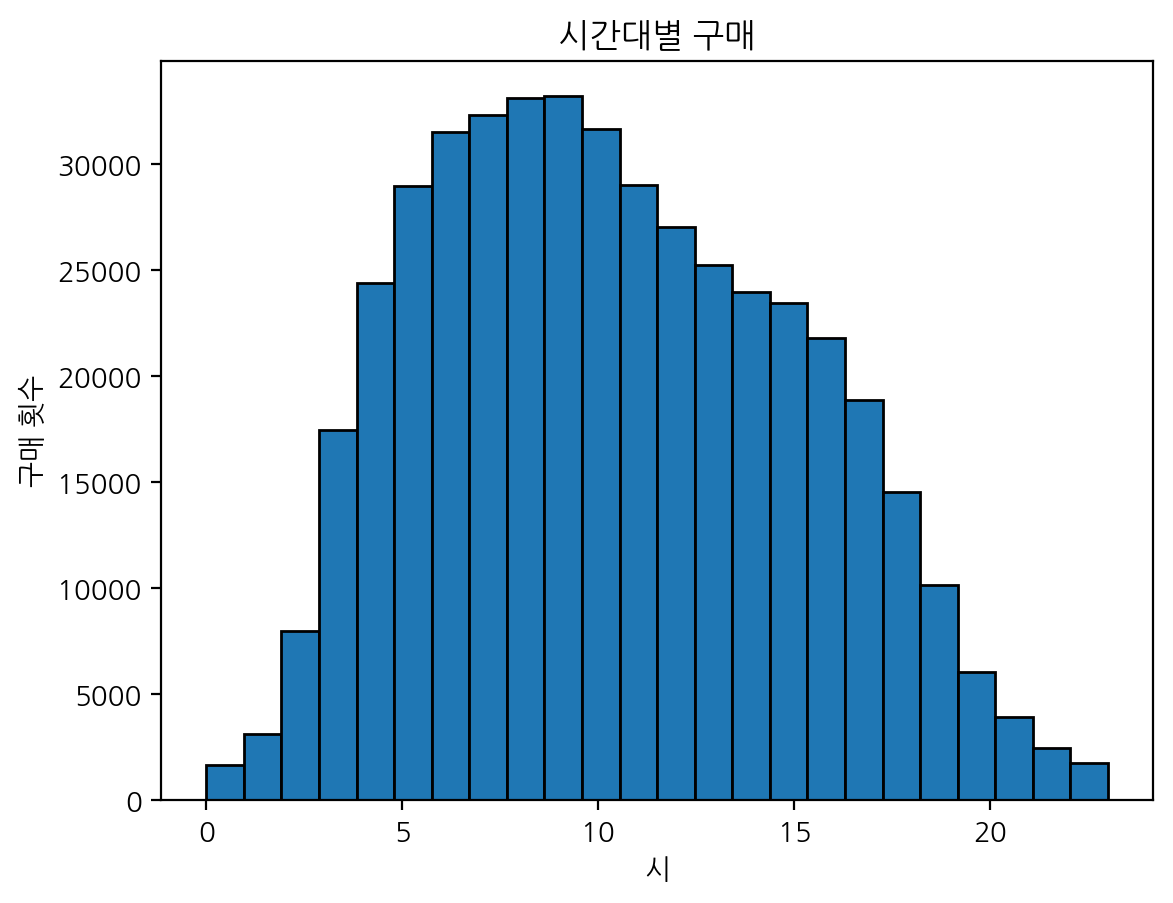

In [28]:
# 전체 집단에서 구매가 가장 많은 시간 시각화
# 테두리가 안보여서 edgecolor를넣음
plt.hist(df_merged['hour'], bins=24, edgecolor='black')
plt.xlabel('시')
plt.ylabel('구매 횟수')
plt.title('시간대별 구매')
plt.show()

# 의외로 출근후~ 점심식사 전이 가장 많음(출근해서 쇼핑하는듯)

In [29]:
# RFM_class, hour, count를 groupby
df_hour = df_merged.groupby(['RFM_class', 'hour'])['event_type'].count().reset_index(name='count')
df_hour

,RFM_class,hour,count
0,silver,0,243
1,silver,1,590
2,silver,2,1594
3,silver,3,3244
4,silver,4,4506
...,...,...,...
67,platinum,19,6822
68,platinum,20,4234
69,platinum,21,2814
70,platinum,22,1758


In [30]:
# 집단별로 나눠서 변수지정

gold = df_hour[df_hour['RFM_class'] == 'gold']
silver = df_hour[df_hour['RFM_class'] == 'silver']
platinum = df_hour[df_hour['RFM_class'] == 'platinum']

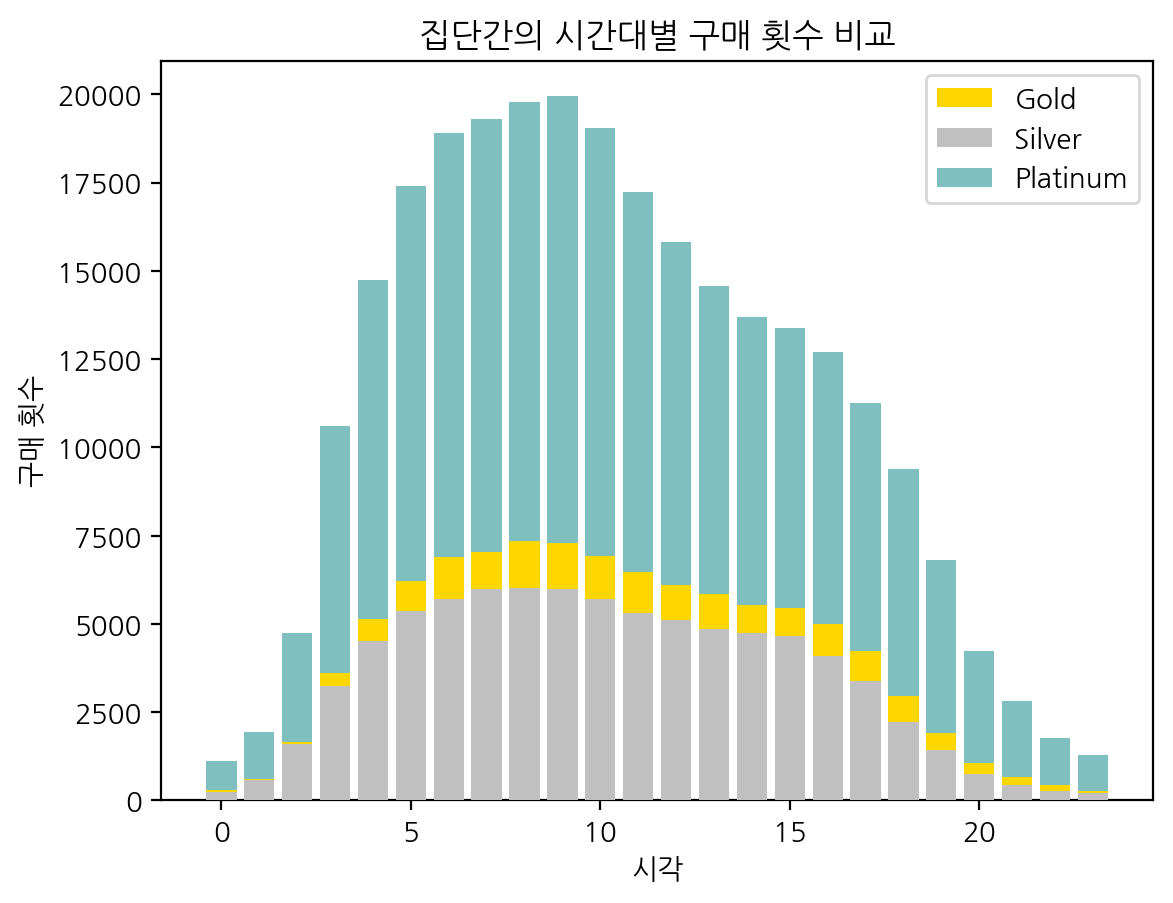

In [31]:
# 서브플롯을 사용해서 한번에 겹쳐그리기
# alpha로 투명도를 조절함
# zorder를 통해 그래프색상이 겹치는것을 해결(어떤 그래프가 앞에나올지 결정)

fig, ax = plt.subplots()

ax.bar(gold['hour'], gold['count'], color='gold', alpha=1, label='Gold', zorder=2)
ax.bar(silver['hour'], silver['count'], color='silver', alpha=1, label='Silver', zorder=3)
ax.bar(platinum['hour'], platinum['count'], color='#008080', alpha=0.5, label='Platinum', zorder=1)

ax.set_xlabel('시각')
ax.set_ylabel('구매 횟수')
ax.set_title('집단간의 시간대별 구매 횟수 비교')
ax.legend()

plt.show()

In [32]:
print(df_merged[df_merged['RFM_class'] == 'gold'].shape, df_merged[df_merged['RFM_class'] == 'silver'].shape,
df_merged[df_merged['RFM_class'] == 'platinum'].shape)

(98911, 18) (82395, 18) (272452, 18)


### 고객 집단별 시간대별로 많이 구매한 제품의 카테고리

In [33]:
# 집단별로 시간, 카테고리 코드, 구매 횟수를 groupby해줌
df_count = df_merged.groupby(['RFM_class', 'hour', 'category_code']).size().reset_index(name='count')
df_count

,RFM_class,hour,category_code,count
0,silver,0,accessories.bag,1
1,silver,0,accessories.umbrella,0
2,silver,0,accessories.wallet,0
3,silver,0,apparel.belt,0
4,silver,0,apparel.costume,0
...,...,...,...,...
8635,platinum,23,sport.ski,0
8636,platinum,23,sport.snowboard,0
8637,platinum,23,sport.tennis,0
8638,platinum,23,sport.trainer,0


In [34]:
#집단별 그룹으로 나눠줌
df_count_gold = df_count[df_count['RFM_class'] == 'gold']
df_count_silver = df_count[df_count['RFM_class'] == 'silver']
df_count_platinum = df_count[df_count['RFM_class'] == 'platinum']
df_count_gold

,RFM_class,hour,category_code,count
2880,gold,0,accessories.bag,4
2881,gold,0,accessories.umbrella,0
2882,gold,0,accessories.wallet,0
2883,gold,0,apparel.belt,0
2884,gold,0,apparel.costume,0
...,...,...,...,...
5755,gold,23,sport.ski,0
5756,gold,23,sport.snowboard,0
5757,gold,23,sport.tennis,0
5758,gold,23,sport.trainer,0


In [35]:
# 어떤제품이 가장많은지 살펴봄
df_count_gold.sort_values(by='count', ascending=False)

,RFM_class,hour,category_code,count
4051,gold,9,electronics.smartphone,4325
3931,gold,8,electronics.smartphone,4242
4171,gold,10,electronics.smartphone,4092
3811,gold,7,electronics.smartphone,4060
3691,gold,6,electronics.smartphone,3995
...,...,...,...,...
3225,gold,2,furniture.living_room.sofa,0
4812,gold,16,apparel.shoes.ballet_shoes,0
3226,gold,2,furniture.universal.light,0
4810,gold,16,apparel.shirt,0


In [36]:
# 0시일때 가장 많이 팔린 제품
df_count_gold[df_count_gold['hour'] == 0].sort_values(by='count', ascending=False)['category_code'].iloc[0]

'electronics.smartphone'

In [37]:
# 반복문을 사용해서 0시~23시까지의 카테고리 코드중 가장 많이 팔린 제품을 출력
# idxmax()는 가장 큰 값을 가진 index를 반환하는 메소드임
for hour in range(0, 24):
    hour_n = df_count_gold[df_count_gold['hour'] == hour]
    result = hour_n.loc[hour_n['count'].idxmax(), 'category_code']
    print(f"{hour}: {result}")

0: electronics.smartphone
1: electronics.smartphone
2: electronics.smartphone
3: electronics.smartphone
4: electronics.smartphone
5: electronics.smartphone
6: electronics.smartphone
7: electronics.smartphone
8: electronics.smartphone
9: electronics.smartphone
10: electronics.smartphone
11: electronics.smartphone
12: electronics.smartphone
13: electronics.smartphone
14: electronics.smartphone
15: electronics.smartphone
16: electronics.smartphone
17: electronics.smartphone
18: electronics.smartphone
19: electronics.smartphone
20: electronics.smartphone
21: electronics.smartphone
22: electronics.smartphone
23: electronics.smartphone


In [38]:
# gold 집단의 시간대별 많이팔린 제품 확인하기
# 첫번째는 electronics.smartphone이라서 의미없어서 2번째것을 가져옴
# n값을 바꿔가면서 몇번째가 가장 많이 팔린지 확인가능

n=2
for hour in range(0, 24):
    hour_n = df_count_gold[df_count_gold['hour'] == hour]
    result = hour_n.nlargest(n, 'count')['category_code'].iloc[n-1]
    print(f"{hour}: {result}")

0: electronics.audio.headphone
1: electronics.audio.headphone
2: electronics.audio.headphone
3: electronics.audio.headphone
4: electronics.audio.headphone
5: electronics.audio.headphone
6: electronics.audio.headphone
7: electronics.audio.headphone
8: electronics.audio.headphone
9: electronics.audio.headphone
10: electronics.audio.headphone
11: electronics.audio.headphone
12: electronics.audio.headphone
13: electronics.audio.headphone
14: electronics.video.tv
15: electronics.audio.headphone
16: electronics.audio.headphone
17: electronics.audio.headphone
18: electronics.audio.headphone
19: electronics.audio.headphone
20: electronics.audio.headphone
21: electronics.audio.headphone
22: electronics.audio.headphone
23: electronics.audio.headphone


In [42]:
# silver 집단의 시간대별 많이팔린 제품 확인하기

n=10
for hour in range(0, 24):
    hour_n = df_count_silver[df_count_silver['hour'] == hour]
    result = hour_n.nlargest(n, 'count')['category_code'].iloc[n-1]
    print(f"{hour}: {result}")

0: appliances.environment.water_heater
1: appliances.kitchen.microwave
2: appliances.kitchen.refrigerators
3: computers.notebook
4: appliances.environment.water_heater
5: appliances.kitchen.kettle
6: appliances.iron
7: appliances.iron
8: electronics.telephone
9: appliances.kitchen.microwave
10: electronics.telephone
11: electronics.telephone
12: appliances.kitchen.microwave
13: appliances.environment.air_heater
14: appliances.iron
15: apparel.shoes
16: apparel.shoes
17: apparel.shoes
18: auto.accessories.player
19: electronics.audio.subwoofer
20: electronics.telephone
21: electronics.audio.subwoofer
22: appliances.environment.air_heater
23: computers.notebook


In [41]:
# platinum 집단의 시간대별 많이팔린 제품 확인하기

n=22
for hour in range(0, 24):
    hour_n = df_count_platinum[df_count_platinum['hour'] == hour]
    result = hour_n.nlargest(n, 'count')['category_code'].iloc[n-1]
    print(f"{hour}: {result}")

0: appliances.environment.water_heater
1: furniture.kitchen.chair
2: electronics.audio.subwoofer
3: auto.accessories.player
4: construction.tools.saw
5: kids.carriage
6: computers.peripherals.printer
7: appliances.kitchen.kettle
8: appliances.kitchen.meat_grinder
9: computers.components.videocards
10: auto.accessories.alarm
11: auto.accessories.alarm
12: appliances.kitchen.kettle
13: appliances.environment.water_heater
14: appliances.sewing_machine
15: apparel.shoes.keds
16: construction.tools.saw
17: appliances.kitchen.blender
18: kids.carriage
19: appliances.iron
20: computers.peripherals.printer
21: electronics.camera.video
22: appliances.personal.hair_cutter
23: kids.dolls


### 나머지는 Tableau로 진행

